# Loading Data



In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json # for colab if you upload the kaggle.json
# !mv ../input/kaggle-json/kaggle.json /root/.kaggle/kaggle.json # for kaggle if you upload your kaggle.json in a folder called 'kaggle-json'
!kaggle datasets download -d marcosvolpato/edible-and-poisonous-fungi
!mkdir dataset && unzip -q edible-and-poisonous-fungi.zip -d dataset
%cd dataset

 93% 239M/257M [00:02<00:00, 79.6MB/s]
100% 257M/257M [00:02<00:00, 101MB/s] 
/content/dataset


In [ ]:
!ls -l

total 128
drwxr-xr-x 2 root root 24576 Nov 21 04:53 'edible mushroom sporocarp'
drwxr-xr-x 2 root root 20480 Nov 21 04:53 'edible sporocarp'
drwxr-xr-x 2 root root 32768 Nov 21 04:53 'poisonous mushroom sporocarp'
drwxr-xr-x 2 root root 53248 Nov 21 04:53 'poisonous sporocarp'


In [ ]:
import glob
# base_path = "/kaggle/input/edible-and-poisonous-fungi/" # for kaggle
base_path = "" # for colab
edible_fungies = glob.glob(base_path + "edible mushroom sporocarp/*") + glob.glob(base_path + "edible sporocarp/*")
poisonous_fungies = glob.glob(base_path + "poisonous mushroom sporocarp/*") + glob.glob(base_path + "poisonous sporocarp/*")
 # the way to get the same amount of edible imgs
# non_edible = [glob.glob("poisonous mushroom sporocarp/*")[:590] + glob.glob("poisonous sporocarp/*")[:591]]
len(edible_fungies), len(poisonous_fungies)

(1181, 2220)

In [ ]:
import numpy as np
X = np.array(edible_fungies + poisonous_fungies)
y = np.concatenate((np.ones(len(edible_fungies)), np.zeros(len(poisonous_fungies))))
len(X), len(y)

(3401, 3401)

# Preprocessing Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, stratify=y_train)
print(f'Training sets: X_train = {X_train.shape}, y_train = {y_train.shape}')
print(f'Validation sets: X_train = {X_val.shape}, y_train = {y_val.shape}')
print(f'Testing sets: X_test = {X_test.shape}, y_test = {y_test.shape}')

Training sets: X_train = (2448,), y_train = (2448,)
Validation sets: X_train = (612,), y_train = (612,)
Testing sets: X_test = (341,), y_test = (341,)


In [ ]:
import tensorflow as tf
def preprocessing_wrapper(input_shape, scaling=False, extra_transformation=None):
    def preprocess_img(item):
        image_string = tf.io.read_file(item[0])
        image_decoded = tf.image.decode_jpeg(image_string, channels=input_shape[2])
        if input_shape: # if input_shape it's empty, don't resize
            image = tf.image.resize(image_decoded, (input_shape[0], input_shape[1]))
        image = tf.cast(image, tf.float32)
        if scaling:
            image = image / 255.0
        if extra_transformation:
            image = extra_transformation(image)
        label = tf.strings.to_number(item[1], tf.float32)
        return image, label
    return preprocess_img

In [ ]:
def get_data(X_train, y_train, X_val, y_val, img_side_size, batch_size, scaling=False, extra_transformation=None):
    img_side_size = img_side_size
    input_shape = (img_side_size,) * 2 + (3,)
    preprocess_image = preprocessing_wrapper(input_shape, scaling=scaling, extra_transformation=extra_transformation)
    dataset_train = tf.data.Dataset.from_tensor_slices(np.array(list(zip(X_train, y_train))))
    dataset_train = dataset_train.map(preprocess_image).batch(batch_size)
    dataset_val = tf.data.Dataset.from_tensor_slices(np.array(list(zip(X_val, y_val))))
    dataset_val = dataset_val.map(preprocess_image).batch(batch_size)
    return dataset_train, dataset_val

In case of having multiple GPUs

In [ ]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


# Model Selection

## AlexNet

In [ ]:
batch_size = 32
dataset_train, dataset_val = get_data(X_train, y_train, X_val, y_val, 224, batch_size, scaling=True)

In [ ]:
 # AlexNet
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(224,224,3))
layers = Conv2D(96, (11,11), 4, activation='relu')(inputs)
layers = MaxPooling2D((3,3), 2)(layers)
layers = Conv2D(256, (5,5), activation='relu')(layers)
layers = MaxPooling2D((3,3), 2)(layers)
layers = Conv2D(384, (3,3), activation='relu')(layers)
layers = Conv2D(384, (3,3), activation='relu')(layers)
layers = Conv2D(256, (3,3), activation='relu')(layers)
layers = MaxPooling2D((3,3), 2)(layers)
layers = Flatten()(layers)
layers = Dense(4096, activation='relu')(layers)
layers = Dropout(0.5)(layers)
layers = Dense(2043, activation='relu')(layers)
layers = Dropout(0.5)(layers)
predictions = Dense(1, activation='sigmoid')(layers)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         885120

In [ ]:
model.fit(dataset_train, epochs=50, batch_size=batch_size, validation_data=dataset_val);

Epoch 1/50
77/77 [==============================] - 23s 114ms/step - loss: 0.6646 - accuracy: 0.6499 - val_loss: 0.6468 - val_accuracy: 0.6520
Epoch 2/50
77/77 [==============================] - 8s 110ms/step - loss: 0.6481 - accuracy: 0.6528 - val_loss: 0.6479 - val_accuracy: 0.6520
Epoch 3/50
77/77 [==============================] - 8s 109ms/step - loss: 0.6462 - accuracy: 0.6528 - val_loss: 0.6474 - val_accuracy: 0.6520
Epoch 4/50
77/77 [==============================] - 9s 121ms/step - loss: 0.6487 - accuracy: 0.6528 - val_loss: 0.6478 - val_accuracy: 0.6520
Epoch 5/50
77/77 [==============================] - 9s 113ms/step - loss: 0.6473 - accuracy: 0.6528 - val_loss: 0.6478 - val_accuracy: 0.6520
Epoch 6/50
77/77 [==============================] - 7s 91ms/step - loss: 0.6487 - accuracy: 0.6528 - val_loss: 0.6471 - val_accuracy: 0.6520
Epoch 7/50
77/77 [==============================] - 9s 113ms/step - loss: 0.6474 - accuracy: 0.6528 - val_loss: 0.6473 - val_accuracy: 0.6520
Epoch 

## MobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
dataset_train, dataset_val = get_data(X_train, y_train, X_val, y_val, 224, batch_size, extra_transformation=preprocess_input)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
modelM = MobileNetV2(input_shape=(224,224,3))
modelM.trainable = False # Way better results when the base model isn't trained
model = tf.keras.Sequential([
    modelM,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1000)              3538984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0 

In [ ]:
model.fit(dataset_train, epochs=50, batch_size=batch_size, validation_data=dataset_val);

Epoch 1/50
77/77 [==============================] - 27s 152ms/step - loss: 0.6407 - accuracy: 0.6475 - val_loss: 0.6114 - val_accuracy: 0.6520
Epoch 2/50
77/77 [==============================] - 8s 97ms/step - loss: 0.5962 - accuracy: 0.6716 - val_loss: 0.5866 - val_accuracy: 0.6732
Epoch 3/50
77/77 [==============================] - 7s 92ms/step - loss: 0.5771 - accuracy: 0.6846 - val_loss: 0.5744 - val_accuracy: 0.6863
Epoch 4/50
77/77 [==============================] - 8s 100ms/step - loss: 0.5663 - accuracy: 0.6895 - val_loss: 0.5653 - val_accuracy: 0.6895
Epoch 5/50
77/77 [==============================] - 9s 117ms/step - loss: 0.5582 - accuracy: 0.6900 - val_loss: 0.5623 - val_accuracy: 0.6928
Epoch 6/50
77/77 [==============================] - 7s 92ms/step - loss: 0.5564 - accuracy: 0.6867 - val_loss: 0.5569 - val_accuracy: 0.6928
Epoch 7/50
77/77 [==============================] - 10s 132ms/step - loss: 0.5557 - accuracy: 0.6855 - val_loss: 0.5583 - val_accuracy: 0.6863
Epoch 8

## ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
dataset_train, dataset_val = get_data(X_train, y_train, X_val, y_val, 224, batch_size, extra_transformation=preprocess_input)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(input_shape=(224,224,3))
# base_model.trainable = False # Way better results when the base model isn't trained
modelR = BatchNormalization()(base_model.output)
modelR = Dense(256, activation='relu')(modelR)
modelR = Dropout(0.5)(modelR)
modelR = Dense(1, activation='sigmoid')(modelR)
modelR = Model(inputs=base_model.input, outputs=modelR)
modelR.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
modelR.fit(dataset_train, epochs=50, batch_size=batch_size, validation_data=dataset_val); # trainable True

Epoch 1/50
77/77 [==============================] - 65s 417ms/step - loss: 0.6451 - accuracy: 0.6438 - val_loss: 0.6463 - val_accuracy: 0.6520
Epoch 2/50
77/77 [==============================] - 29s 379ms/step - loss: 0.6514 - accuracy: 0.6511 - val_loss: 0.6470 - val_accuracy: 0.6520
Epoch 3/50
77/77 [==============================] - 30s 382ms/step - loss: 0.6429 - accuracy: 0.6524 - val_loss: 0.6470 - val_accuracy: 0.6520
Epoch 4/50
77/77 [==============================] - 29s 380ms/step - loss: 0.6309 - accuracy: 0.6520 - val_loss: 0.6472 - val_accuracy: 0.6520
Epoch 5/50
77/77 [==============================] - 27s 349ms/step - loss: 0.6347 - accuracy: 0.6491 - val_loss: 0.6542 - val_accuracy: 0.6520
Epoch 6/50
77/77 [==============================] - 29s 373ms/step - loss: 0.6298 - accuracy: 0.6536 - val_loss: 0.6325 - val_accuracy: 0.6520
Epoch 7/50
77/77 [==============================] - 27s 354ms/step - loss: 0.6182 - accuracy: 0.6601 - val_loss: 0.6329 - val_accuracy: 0.6503

In [ ]:
modelR.fit(dataset_train, epochs=50, batch_size=batch_size, validation_data=dataset_val); # trainable False

Epoch 1/50
77/77 [==============================] - 57s 575ms/step - loss: 0.6355 - accuracy: 0.6138 - val_loss: 0.6126 - val_accuracy: 0.6585
Epoch 2/50
77/77 [==============================] - 18s 233ms/step - loss: 0.5360 - accuracy: 0.6949 - val_loss: 0.5955 - val_accuracy: 0.6814
Epoch 3/50
77/77 [==============================] - 17s 227ms/step - loss: 0.5146 - accuracy: 0.7306 - val_loss: 0.5767 - val_accuracy: 0.6846
Epoch 4/50
77/77 [==============================] - 18s 231ms/step - loss: 0.4980 - accuracy: 0.7349 - val_loss: 0.5601 - val_accuracy: 0.6928
Epoch 5/50
77/77 [==============================] - 18s 235ms/step - loss: 0.4796 - accuracy: 0.7516 - val_loss: 0.5465 - val_accuracy: 0.6993
Epoch 6/50
77/77 [==============================] - 18s 228ms/step - loss: 0.4608 - accuracy: 0.7652 - val_loss: 0.5426 - val_accuracy: 0.7059
Epoch 7/50
77/77 [==============================] - 18s 228ms/step - loss: 0.4518 - accuracy: 0.7710 - val_loss: 0.5469 - val_accuracy: 0.7026

## EfficientNetB3

In [ ]:
dataset_train, dataset_val = get_data(X_train, y_train, X_val, y_val, 300, batch_size)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model

base_model = EfficientNetB3(input_shape=(300,300,3))
modelE = BatchNormalization()(base_model.output)
modelE = Dense(256, activation='relu')(modelE)
modelE = Dropout(0.5)(modelE)
modelE = Dense(1, activation='sigmoid')(modelE)
modelE = Model(inputs=base_model.input, outputs=modelE)
modelE.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

50095040/50095040 [==============================] - 1s 0us/step


In [ ]:
modelE.fit(dataset_train, epochs=50, batch_size=batch_size, validation_data=dataset_val); # trainable True

Epoch 1/50
77/77 [==============================] - 139s 1s/step - loss: 0.5572 - accuracy: 0.7198 - val_loss: 0.6434 - val_accuracy: 0.6520
Epoch 2/50
77/77 [==============================] - 78s 1s/step - loss: 0.5092 - accuracy: 0.7533 - val_loss: 0.6171 - val_accuracy: 0.6520
Epoch 3/50
77/77 [==============================] - 77s 1s/step - loss: 0.4707 - accuracy: 0.7929 - val_loss: 0.6770 - val_accuracy: 0.6618
Epoch 4/50
77/77 [==============================] - 78s 1s/step - loss: 0.4493 - accuracy: 0.8056 - val_loss: 0.6670 - val_accuracy: 0.7026
Epoch 5/50
77/77 [==============================] - 79s 1s/step - loss: 0.3817 - accuracy: 0.8386 - val_loss: 0.5319 - val_accuracy: 0.7549
Epoch 6/50
77/77 [==============================] - 79s 1s/step - loss: 0.3202 - accuracy: 0.8766 - val_loss: 0.5027 - val_accuracy: 0.7958
Epoch 7/50
77/77 [==============================] - 79s 1s/step - loss: 0.2517 - accuracy: 0.9109 - val_loss: 0.7635 - val_accuracy: 0.7059
Epoch 8/50
77/77 [=

In [ ]:
modelE.fit(dataset_train, epochs=50, batch_size=batch_size, validation_data=dataset_val); # trainable False

Epoch 1/50
77/77 [==============================] - 44s 383ms/step - loss: 0.5926 - accuracy: 0.6679 - val_loss: 0.6137 - val_accuracy: 0.6520
Epoch 2/50
77/77 [==============================] - 20s 260ms/step - loss: 0.5374 - accuracy: 0.6961 - val_loss: 0.5946 - val_accuracy: 0.6667
Epoch 3/50
77/77 [==============================] - 21s 269ms/step - loss: 0.5211 - accuracy: 0.7096 - val_loss: 0.5796 - val_accuracy: 0.6830
Epoch 4/50
77/77 [==============================] - 21s 279ms/step - loss: 0.5157 - accuracy: 0.7243 - val_loss: 0.5719 - val_accuracy: 0.6765
Epoch 5/50
77/77 [==============================] - 20s 261ms/step - loss: 0.5034 - accuracy: 0.7206 - val_loss: 0.5617 - val_accuracy: 0.6944
Epoch 6/50
77/77 [==============================] - 21s 277ms/step - loss: 0.5020 - accuracy: 0.7279 - val_loss: 0.5561 - val_accuracy: 0.6928
Epoch 7/50
77/77 [==============================] - 22s 277ms/step - loss: 0.4916 - accuracy: 0.7267 - val_loss: 0.5515 - val_accuracy: 0.6961

The EfficientNetB3 model trained including the already trained weights.

# Model Evaluation

In [ ]:
dataset_test = get_test_data(X_test, y_test, 300, batch_size)
results = modelE.evaluate(dataset_test)
results

77/77 [==============================] - 13s 169ms/step - loss: 0.1053 - accuracy: 0.9632


[0.10533688217401505, 0.9632353186607361]

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = []
true_labels = []

for inputs, labels in dataset_test:
    predictions.extend(np.round(modelE.predict(inputs)))  # Assuming a sigmoid activation in the last layer
    true_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix

In [ ]:
conf_matrix

array([[1536,   62],
       [  28,  822]])

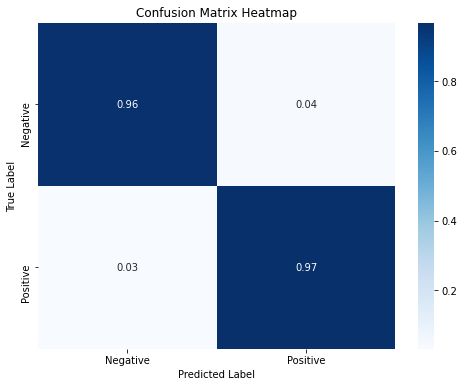

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have computed the confusion matrix (conf_matrix)
# using the code in the previous response.

# Labels for the confusion matrix
class_names = ['Negative', 'Positive']

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
